#Libraries

In [1]:
import pandas as pd
import numpy as np 

In [2]:
df_train=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competitions/Loan Prediction/train_ctrUa4K.csv')

In [3]:
df_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

# Data Cleaning

In [4]:
def categorical_to_binary(data,ohe_pa,ohe_dep):
  data['Gender']=data['Gender'].map({'Male':1,'Female':0})
  data['Married']=data['Married'].map({'Yes':1,'No':0})
  data['Education']=data['Education'].map({'Graduate':1,'Not Graduate':0})
  data['Self_Employed']=data['Self_Employed'].map({'Yes':1,'No':0})
  
  dependents=pd.DataFrame(ohe_dep.transform(data[['Dependents']]),columns=['0','1','2'])

  property_area=pd.DataFrame(ohe_pa.transform(data[['Property_Area']]),columns=['Urban','Rural'])
  data.drop(['Property_Area','Dependents'],axis=1,inplace=True)
  data=pd.concat([data,property_area,dependents],axis=1)

  return data 

In [5]:
def remove_missing_value_num(data,knn_num):
  missing_num=['LoanAmount','Loan_Amount_Term','Credit_History']
  missing_value1=pd.DataFrame(data=knn_num.transform(data[missing_num]),columns=missing_num)
  
  data.drop('CoapplicantIncome',axis=1,inplace=True)
  data.drop(missing_num,axis=1,inplace=True)
  data=pd.concat([data,missing_value1],axis=1)

  return data  

In [6]:
def remove_missing_value_cat(data,si):
  missing_col=['Gender','Married','Dependents','Self_Employed']
  filled_values=pd.DataFrame(data=si.transform(data[missing_col]),columns=missing_col)

  data.drop(missing_col,axis=1,inplace=True)
  data=pd.concat([data,filled_values],axis=1)

  return data

In [7]:
def upsampling(data):
  data_majority=data[data['Loan_Status']=='Y']
  data_minority=data[data['Loan_Status']=='N']

  from sklearn.utils import resample

  data_minority_upsampled = resample(data_minority, 
                                 replace=True,   
                                 n_samples=len(data_majority),    
                                 random_state=123)
  
  data=pd.concat([data_majority,data_minority_upsampled])

  return data

# Implementing the functions

In [8]:
missing_col=['Gender','Married','Dependents','Self_Employed']
from sklearn.impute import SimpleImputer
si=SimpleImputer(strategy='most_frequent')
si.fit(df_train[missing_col])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [9]:
df_train=remove_missing_value_cat(df_train,si)

In [10]:
from sklearn.preprocessing import OneHotEncoder
ohe_pa=OneHotEncoder(sparse=False,drop='first')
ohe_pa.fit(df_train[['Property_Area']])

OneHotEncoder(categories='auto', drop='first', dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [11]:
ohe_dep=OneHotEncoder(sparse=False,drop='first')
ohe_dep.fit(df_train[['Dependents']])

OneHotEncoder(categories='auto', drop='first', dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [12]:
from sklearn.impute import KNNImputer
knn_impute_num=KNNImputer()
missing_num=['LoanAmount','Loan_Amount_Term','Credit_History']
knn_impute_num.fit(df_train[missing_num])

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [13]:
df_train=categorical_to_binary(df_train,ohe_pa,ohe_dep)

In [14]:
df_train=remove_missing_value_num(df_train,knn_impute_num)

In [15]:
#df_train=upsampling(df_train)

# Model creation

In [16]:
df_train.head()

,Loan_ID,Education,ApplicantIncome,Loan_Status,Gender,Married,Self_Employed,Urban,Rural,0,1,2,LoanAmount,Loan_Amount_Term,Credit_History
0,LP001002,1,5849,Y,1,0,0,0.0,1.0,0.0,0.0,0.0,164.6,360.0,1.0
1,LP001003,1,4583,N,1,1,0,0.0,0.0,1.0,0.0,0.0,128.0,360.0,1.0
2,LP001005,1,3000,Y,1,1,1,0.0,1.0,0.0,0.0,0.0,66.0,360.0,1.0
3,LP001006,0,2583,Y,1,1,0,0.0,1.0,0.0,0.0,0.0,120.0,360.0,1.0
4,LP001008,1,6000,Y,1,0,0,0.0,1.0,0.0,0.0,0.0,141.0,360.0,1.0


In [17]:
df_train['Loan_Status']=df_train['Loan_Status'].map({'Y':1,'N':0})
y=df_train['Loan_Status']
x=df_train.drop(['Loan_Status','Loan_ID'],axis=1)

In [18]:
print(len(x))
print(len(y))

614
614


In [19]:
x.shape

(614, 13)

#Scaler

In [20]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()
x_scaled=mms.fit_transform(x)

#Feature Selection

In [21]:
from sklearn.feature_selection import mutual_info_classif
relation_targets=pd.DataFrame(mutual_info_classif(x_scaled,y),columns=['Relation_with_target'])
relation_targets['columns']=x.columns

In [22]:
relation_targets.sort_values('Relation_with_target',ascending=False)

,Relation_with_target,columns
12,0.146649,Credit_History
4,0.028170,Self_Employed
2,0.024739,Gender
5,0.012775,Urban
1,0.008408,ApplicantIncome
0,0.000000,Education
3,0.000000,Married
6,0.000000,Rural
7,0.000000,0
8,0.000000,1


In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
skb=SelectKBest(score_func=chi2,k=x.shape[1])

In [25]:
skb.fit(x_scaled,y)

SelectKBest(k=13, score_func=<function chi2 at 0x7f5ca873d510>)

In [26]:
best_features=pd.DataFrame(skb.scores_,columns=['Chi2 Score'])
best_features['Column']=x.columns

In [27]:
best_features.sort_values('Chi2 Score',ascending=False)

,Chi2 Score,Column
12,24.689650,Credit_History
5,7.103093,Urban
8,1.996446,1
3,1.782425,Married
0,0.988390,Education
6,0.783946,Rural
7,0.768400,0
9,0.384200,2
10,0.047199,LoanAmount
2,0.036234,Gender


#Kflod

In [28]:
from sklearn.model_selection import StratifiedKFold
skf_10=StratifiedKFold(n_splits=10,shuffle=True)

# Metrics

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

In [30]:
from sklearn.model_selection import cross_val_score

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt


#Selecting Model

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [32]:
models=[]
models.append(("LogReg",LogisticRegression()))
models.append(("DesicionTree",DecisionTreeClassifier()))
models.append(("SVC",SVC()))
models.append(("kNN",KNeighborsClassifier()))
models.append(("RandomForest",RandomForestClassifier()))

In [33]:
names=[]
result=[]
scoring='accuracy'
for name,model in models:
  cv_result=cross_val_score(model,x_scaled,y,scoring=scoring,cv=skf_10)
  print("Model created: %s ------> Validation Error: %.2f" % (name,cv_result.mean()))
  print("-----------------------------------------------")

Model created: LogReg ------> Validation Error: 0.80
-----------------------------------------------
Model created: DesicionTree ------> Validation Error: 0.68
-----------------------------------------------
Model created: SVC ------> Validation Error: 0.80
-----------------------------------------------
Model created: kNN ------> Validation Error: 0.75
-----------------------------------------------
Model created: RandomForest ------> Validation Error: 0.79
-----------------------------------------------


### Testing the model with SVC , LogReg and RandomForest for Hyperparameter Tuning

# Testing various model 

In [46]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(x_scaled,y,test_size=0.25,random_state=0)

In [34]:
from sklearn.model_selection import GridSearchCV
import numpy as np

## Log Reg

In [35]:
log_params={'tol':[0.01,0.001,0.0001,0.00001],
            'max_iter':np.linspace(100,500,10),
            'class_weight':['None','balanced']
          }

In [36]:
grid_log=GridSearchCV(estimator=LogisticRegression(n_jobs=-1),
                          param_grid=log_params)

In [47]:
grid_log.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ['None', 'balanced'],
                         'max_iter': array([100.        , 144.44444444, 188.88888889, 233.33333333,
       277.77777778, 322.22222222, 366.66666667, 411.11111111,
       455.55555556, 500.        ]),
                         'tol': [0.01, 0.001, 0.0001, 1e-05]},
             pre_dispatch

In [38]:
grid_log.best_score_

0.8013194722111155

In [48]:
print(classification_report(y_valid,grid_log.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.79      0.44      0.57        43
           1       0.82      0.95      0.88       111

    accuracy                           0.81       154
   macro avg       0.80      0.70      0.72       154
weighted avg       0.81      0.81      0.79       154



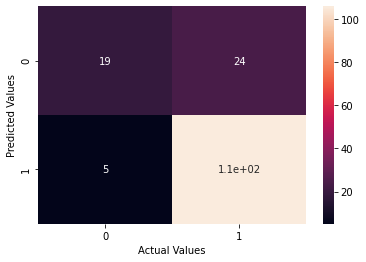

In [55]:
sns.heatmap(confusion_matrix(y_valid,grid_log.predict(x_valid)),annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## KNN

In [39]:
knn_params={'n_neighbors':[5,10,15,40],
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'weights':['uniform', 'distance'],
            'metric' :['euclidean', 'manhattan', 'minkowski'],
            'leaf_size':[20,30,40,50],
            }

In [40]:
grid_knn=GridSearchCV(KNeighborsClassifier(),knn_params)

In [56]:
grid_knn.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [20, 30, 40, 50],
                         'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [5, 10, 15, 40],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [57]:
grid_knn.best_score_

0.7478260869565218

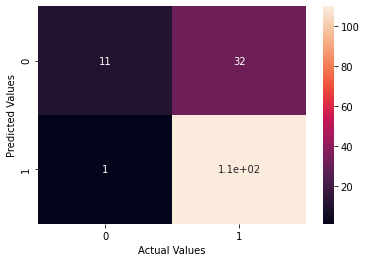

In [58]:
sns.heatmap(confusion_matrix(y_valid,grid_knn.predict(x_valid)),annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## SVM 

In [43]:
svc_params={#'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
            'tol':[0.01,0.001,0.0001],
            'C':[1,10,100]
            }
svc_grid=GridSearchCV(SVC(),param_grid=svc_params,n_jobs=-1)

In [59]:
svc_grid.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [45]:
svc_grid.best_score_

0.8029588164734107

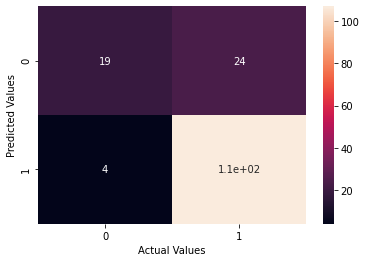

In [60]:
sns.heatmap(confusion_matrix(y_valid,svc_grid.predict(x_valid)),annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Random Forest

In [61]:
rf_params={ 'n_estimators':[50,100,250,500],
           'max_depth':[5,10,20,32],
           'min_samples_split':[2,5,15,25],
           'min_samples_leaf':[1,5,15,20],
           'max_features':['sqrt','log2','auto'],
           'criterion':['gini','entropy']
}

In [62]:
rf_grid=GridSearchCV(RandomForestClassifier(),param_grid=rf_params)

In [63]:
rf_grid.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=No...
                                              random_state=None, verbose=0,
                                   

In [64]:
rf_grid.best_score_

0.8043478260869564

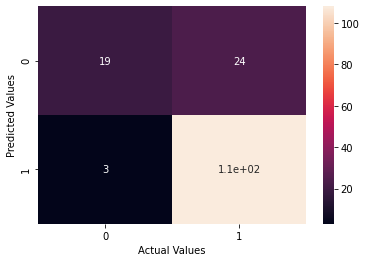

In [65]:
sns.heatmap(confusion_matrix(y_valid,rf_grid.predict(x_valid)),annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

Since we dont want to predict a loan which is bad (0) as good(1) that is false positive. we give priority to model that predict lower false positive

If I create a scenario say predicting a bad loan as good results in a loss of 20k to bank and say predicting a good loan as bad loan results in a loss of 10k to bank. Thus Cost=10k*false negative + 20K*false positive

In [67]:
print("cost of RandomForest ",20000*3+10000*24)
print("cost of KNN ",20000*1+10000*32)
print("cost of SVM ",20000*4+10000*24)
print("cost of LogReg ",20000*5+10000*24)

cost of RandomForest  300000
cost of KNN  340000
cost of SVM  320000
cost of LogReg  340000


Random Forest works best as per above method

#Test Data

In [68]:
test=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competitions/Loan Prediction/test_lAUu6dG.csv')

In [69]:
test=remove_missing_value_cat(test,si)

In [70]:
test=categorical_to_binary(test,ohe_pa,ohe_dep)

In [71]:
test=remove_missing_value_num(test,knn_impute_num)

In [72]:
test_id=test['Loan_ID']
test.drop('Loan_ID',axis=1,inplace=True)

In [73]:
len(test)

367

In [74]:
test_scaled=mms.transform(test)

In [75]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
rf_final=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [77]:
rf_final.fit(x_scaled,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:
pred=rf_final.predict(test_scaled)

In [79]:
result=pd.DataFrame()
result['Loan_ID']=test_id
result['Loan_Status']=pred

In [80]:
result['Loan_Status']=result['Loan_Status'].map({1:'Y',0:'N'})

In [81]:
result['Loan_Status'].value_counts()

Y    308
N     59
Name: Loan_Status, dtype: int64

In [82]:
result

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
...,...,...
362,LP002971,Y
363,LP002975,Y
364,LP002980,Y
365,LP002986,Y
